# HackerEarth Deep Learning Challenge 1 : Predicting the Product Category

In [1]:
%matplotlib inline

In [2]:
## Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.misc import *

In [3]:
import os,sys
from PIL import Image
import cv2 #OpenCV library
from tqdm import tqdm

In [4]:
DATA_HOME_DIR = os.getcwd()
%pwd

'/output'

## Reading the image labels and exploring the datasets

In [5]:
train = pd.read_csv("/data/train.csv")
test = pd.read_csv("/data/test.csv")

In [6]:
train.head()

,image_id,label
0,train_1a,rice
1,train_1b,candy
2,train_1c,jam
3,train_1d,coffee
4,train_2a,vinegar


In [7]:
train.groupby(by = "label").count()

,image_id
label,
beans,88
cake,105
candy,242
cereal,181
chips,118
chocolate,199
coffee,194
corn,63
fish,71


In [8]:
## set path for images
TRAIN_PATH = '/data/train_img/'
TEST_PATH = '/data/test_img/'

Let's check out a few images from the training set along with their labels. 
Resizing to a smaller size (original - 256X256) pixelates the text part of the image.

In [9]:
# function to read images as arrays
def read_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (256,256))
    return img

In [10]:
train_data = []
test_data = []
train_labels = train['label'].values

for img in tqdm(train['image_id'].values):
    train_data.append(read_image(TRAIN_PATH + '{}.png'.format(img)))
    
for img in tqdm(test['image_id'].values):
    test_data.append(read_image(TEST_PATH + '{}.png'.format(img)))

100%|██████████| 1732/1732 [00:41<00:00, 40.98it/s]


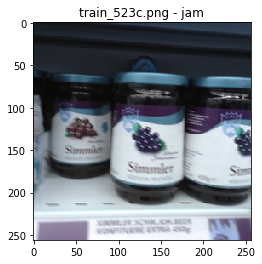

In [11]:
i = np.random.choice(np.arange(len(train_data)))

plt.title('{}.png - {}'.format(train['image_id'].values[i], train_labels[i]))
plt.imshow(train_data[i])

In [11]:
# Scale the images
X_train = np.array(train_data, np.float32) / 255.
X_test = np.array(test_data, np.float32) / 255.

In [12]:
# Encoding image labels into target variables (categorical)
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
le = LabelEncoder()
y_train = le.fit_transform(train_labels)

ohe = OneHotEncoder(categorical_features = [0])
y_train = ohe.fit_transform(y_train.reshape(-1,1)).toarray()

In [13]:
X_train.shape, y_train.shape

((3215, 256, 256, 3), (3215, 25))

In [14]:
## Importing the Keras libraries and packages
import keras
from keras import applications # required for transfer learning
from keras.models import Sequential, Model
from keras.layers import *
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint

Using Theano backend.
Using cuDNN version 5110 on context None
Preallocating 10867/11439 Mb (0.950000) on cuda
Mapped name None to device cuda: Tesla K80 (0000:00:1E.0)


### Transfer Learning with ImageNet pre-trained models (VGG16/ResNet/Inception models etc.)

In [58]:
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

A pre-trained (on ImageNet) VGG-16 architecture is adopted excluding the top/last layer. That layer is later on replaced by few fully-connected, dense and dropout layers.

In [56]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [41]:
from sklearn.metrics import f1_score

In [42]:
def weighted_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average = 'weighted')

In [59]:
## set model architecture - Adding few layers on top of the VGG-16 architecture
add_model = Sequential([
            Flatten(input_shape=base_model.output_shape[1:]),
            Dense(256, activation='relu'),
            Dropout(0.3),
            Dense(y_train.shape[1], activation='softmax')
            ])

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))

In [61]:
model.compile(loss='categorical_crossentropy', optimizer = SGD(lr=1e-3, momentum=0.9), metrics=['accuracy'])

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

Trying to fit the pre-trained VGG16 model with an additional Dense and Dropout layer

In [44]:
# Training the model
model.fit(X_train, y_train, batch_size=32, epochs=2, validation_split=0.2)

Train on 2572 samples, validate on 643 samples
Epoch 1/2
2572/2572 [==============================] - 518s - loss: 0.1441 - acc: 0.9537 - val_loss: 1.3813 - val_acc: 0.6858
Epoch 2/2
2572/2572 [==============================] - 518s - loss: 0.0560 - acc: 0.9841 - val_loss: 1.5763 - val_acc: 0.6905


In [21]:
model.optimizer.lr /= 10

In [ ]:
## Saving weights as a form of model checkpointing
model.save_weights('pre-trained_vgg-16_weights.h5')

 Let's try out data augmentation using ImageDataGenerator to reduce overfitting. The above model (pre-trained VGG16) started overfitting in just about 3 epochs. Ran for 8 epochs, with a little LR decay

In [19]:
from sklearn.cross_validation import train_test_split
X_trn, X_valid, y_trn, y_valid = train_test_split(X_train, y_train, test_size = 0.2)

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [62]:
gen = image.ImageDataGenerator(rotation_range=25, width_shift_range=0.1, shear_range=0.25,
                               height_shift_range=0.1, zoom_range=0.2, horizontal_flip = True)
batches = gen.flow(X_trn, y_trn, batch_size = 32)
val_batches = gen.flow(X_valid, y_valid, batch_size = 64)

In [59]:
for i in range(5):
    print('Epoch {}/5'.format(i+1))
    model.fit_generator(batches, (X_trn.shape[0]//batches.batch_size), epochs=1,
                    validation_data = val_batches, validation_steps = (X_valid.shape[0]//val_batches.batch_size))
    model.save_weights('pre-trained_vgg-16_weights_epoch_{}.h5'.format(i+1))

Epoch 1/5
Epoch 1/1
80/80 [==============================] - 516s - loss: 3.1883 - acc: 0.0852 - val_loss: 2.9637 - val_acc: 0.1469
Epoch 2/5
Epoch 1/1
80/80 [==============================] - 511s - loss: 2.7774 - acc: 0.1943 - val_loss: 2.5222 - val_acc: 0.2418
Epoch 3/5
Epoch 1/1
80/80 [==============================] - 511s - loss: 2.2745 - acc: 0.3323 - val_loss: 2.2260 - val_acc: 0.3420
Epoch 4/5
Epoch 1/1
80/80 [==============================] - 510s - loss: 1.9448 - acc: 0.4144 - val_loss: 1.8952 - val_acc: 0.4197
Epoch 5/5
Epoch 1/1
80/80 [==============================] - 510s - loss: 1.5974 - acc: 0.5163 - val_loss: 1.7309 - val_acc: 0.4870


In [33]:
model.optimizer.lr /= 10

In [62]:
for i in range(5, 10):
    print('Epoch {}/10'.format(i+1))
    model.fit_generator(batches, (X_trn.shape[0]//batches.batch_size), epochs=1,
                    validation_data = val_batches, validation_steps = (X_valid.shape[0]//val_batches.batch_size))
    model.save_weights('pre-trained_vgg-16_weights_epoch_{}.h5'.format(i+1))

Epoch 6/10
Epoch 1/1
80/80 [==============================] - 510s - loss: 1.3877 - acc: 0.5650 - val_loss: 1.6662 - val_acc: 0.5320
Epoch 7/10
Epoch 1/1
80/80 [==============================] - 510s - loss: 1.1837 - acc: 0.6482 - val_loss: 1.5095 - val_acc: 0.5406
Epoch 8/10
Epoch 1/1
80/80 [==============================] - 511s - loss: 1.0359 - acc: 0.6740 - val_loss: 1.3576 - val_acc: 0.6114
Epoch 9/10
Epoch 1/1
80/80 [==============================] - 511s - loss: 0.8489 - acc: 0.7454 - val_loss: 1.0989 - val_acc: 0.6528
Epoch 10/10
Epoch 1/1
80/80 [==============================] - 514s - loss: 0.7099 - acc: 0.7777 - val_loss: 1.2347 - val_acc: 0.6425


In [ ]:
model.save_weights('pre-trained_vgg-16_weights_epoch_15.h5')

In [ ]:
## Loading pre-trained weights from a previous run
model.load_weights('pre-trained_vgg-16_weights_epoch_15.h5')

In [22]:
model.fit_generator(batches, (X_trn.shape[0]//batches.batch_size), epochs=10,
                    validation_data = val_batches, validation_steps = (X_valid.shape[0]//val_batches.batch_size))

Epoch 1/10
80/80 [==============================] - 522s - loss: 0.4677 - acc: 0.8609 - val_loss: 0.3535 - val_acc: 0.9047
Epoch 2/10
80/80 [==============================] - 518s - loss: 0.3918 - acc: 0.8937 - val_loss: 0.3484 - val_acc: 0.8946
Epoch 3/10
80/80 [==============================] - 518s - loss: 0.3849 - acc: 0.8952 - val_loss: 0.2974 - val_acc: 0.9206
Epoch 4/10
80/80 [==============================] - 518s - loss: 0.3548 - acc: 0.8990 - val_loss: 0.3711 - val_acc: 0.8998
Epoch 5/10
80/80 [==============================] - 518s - loss: 0.3254 - acc: 0.9059 - val_loss: 0.3000 - val_acc: 0.9240
Epoch 6/10
80/80 [==============================] - 518s - loss: 0.3052 - acc: 0.9184 - val_loss: 0.3225 - val_acc: 0.9102
Epoch 7/10
80/80 [==============================] - 518s - loss: 0.3086 - acc: 0.9077 - val_loss: 0.2289 - val_acc: 0.9344
Epoch 8/10
80/80 [==============================] - 518s - loss: 0.2975 - acc: 0.9189 - val_loss: 0.2820 - val_acc: 0.9292
Epoch 9/10
80/80

In [35]:
 model.save_weights('pre-trained_vgg-16_weights_epoch_30.h5')

The model ran for 30 epochs with learning rate decay by a factor of 10 from 1e-3 to 1e-5

### Making predictions on test set

In [36]:
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis= 1)

In [37]:
predictions[13:21]

array([13, 11,  2, 18, 17, 12, 16, 23])

In [38]:
unique_labels = np.unique(train['label'].tolist())

In [39]:
# Converting predicted category numbers to predicted labels
pred_labels = unique_labels[predictions]

I see this product is rice


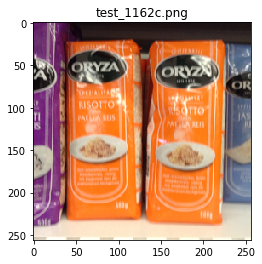

In [31]:
## lets see what our classifier predicts on test images
# Random predictions
i = np.random.choice(np.arange(len(test_data)))
print('I see this product is {}'.format(pred_labels[i]))
plt.title('{}.png'.format(test['image_id'].values[i]))
plt.imshow(Image.open(TEST_PATH +'{}.png'.format(test.image_id[i])))

In [40]:
# Prepare submission file
subm = pd.DataFrame({'image_id':test.image_id, 'label':pred_labels})
subm.to_csv('results.csv', index=False)